## MIE1622 Assignment 3 - Tongfei Li

In [62]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

In [254]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID 100
driver = instr_data[:, 1]       # credit driver 50
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs 100

# Read matrix of correlations for credit drivers 50 x 50
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [255]:
n_driver = len(rho)
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

filename_save_out = 'loss_out'
# -------- Insert your code here -------- #
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    # credit driver factor
    y = np.zeros((Nout,num_drivers))
    # idiosyncratic component
    z = np.random.randn(K,1)
    # loss out of 100,000 scenario 100 counterepaties
    Losses_out = np.zeros((Nout, K))

    # -------- Insert your code here -------- #

    for s in range(1, Nout + 1): # for each scenario
        # -------- Insert your code here -------- #
        # random y for the scenario
        y[s-1,:] = np.dot(sqrt_rho,np.random.randn(n_driver,1)).T
        # loss out of scenario s for each counterparty
        loss_s = []
        for j in range(K): # for each counterparty
            # credit driver for counterparty
            cd = int(driver[j])
#             print(cd)
            # creditworthness
            w = beta[j] * y[s-1,cd-1] + np.sqrt(1-beta[j]**2)*z[j]
            wcs = np.argwhere(sorted(np.append(w, CS_Bdry[j,:])) == w)
            loss_s.append(exposure[j,wcs])

        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
        Losses_out[s-1] = loss_s
    np.save('Losses_out.npy',Losses_out)



/var/folders/7z/6tf98rc93hs5zf3rfz6g5_zm0000gn/T/ipykernel_73954/3750706474.py:44: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Losses_out[s-1] = loss_s


In [256]:
# Normal approximation computed from out-of-sample scenarios
# true distribution
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out, rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])
# 100000 out-of-sample scenarios
VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        # Sort loss data in increasing order
        loss_1d = np.sort(np.dot(Losses_out,x0[portN]))
        # Compute Historical 1-day VaR from the data
        VaRout[portN, q] = loss_1d[int(math.ceil(Nout * alf)) - 1]
        # Compute Normal 1-day VaR from the data
        VaRinN[portN, q] = np.mean(loss_1d) + scs.norm.ppf(alf) * np.std(loss_1d)
        # Compute Historical 1-day CVaR from the data
        CVaRout[portN, q] = (1/(Nout*(1-alf))) * ((math.ceil(Nout*alf)-Nout*alf)* VaRout[portN, q] + sum(loss_1d[int(math.ceil(Nout*alf)):]))
        # Compute Normal 1-day CVaR from the data
        CVaRinN[portN, q] = np.mean(loss_1d) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(loss_1d)



In [257]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)


for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1
    # 1000 systemic scenarios and 5 idiosyncratic scenarios for each systemic

    # -------- Insert your code here -------- #
    # Initialize Scenarios
    # credit driver factor
    y1 = np.zeros((int(Nin/Ns),num_drivers))
    # loss out of 5000 in-sample scenarios, 100 counterepaties
    Losses_inMC1 = np.zeros((Nin, K))


    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # 1000 systemic scenarios
        # -------- Insert your code here -------- #
        # random y for the scenario
        y1[s-1,:] = np.dot(sqrt_rho,np.random.randn(n_driver,1)).T

        for si in range(1, Ns + 1): # 5 idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            # idiosyncratic component
            z1 = np.random.randn(K,1)
            # loss out of scenario s for each counterparty
            loss_s1 = []
            
            for j in range(K): # for 100 counterparty
                # credit driver for counterparty
                cd = int(driver[j])
#               print(cd)
                # creditworthness
                w1 = beta[j] * y1[s-1,cd-1] + np.sqrt(1-beta[j]**2)*z1[j]
                wcs = np.argwhere(sorted(np.append(w1, CS_Bdry[j,:])) == w1)
                loss_s1.append(exposure[j,wcs])
            # Calculate losses for MC1 approximation (5000 x 100)
            # Losses_inMC1 (sparse matrix)
            Losses_inMC1[5*(s-1)+si-1] = loss_s1


    # Monte Carlo approximation 2
    # 5000 systemic scenarios and 1 idiosyncratic scenario for each systemic

    # -------- Insert your code here -------- #
    # Initialize Scenarios
    # credit driver factor
    y2 = np.zeros((Nin,num_drivers))
    # loss out of 5000 in-sample scenarios, 100 counterepaties
    Losses_inMC2 = np.zeros((Nin, K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        # random y for the scenario
        y2[s-1,:] = np.dot(sqrt_rho,np.random.randn(n_driver,1)).T
        # idiosyncratic component
        z2 = np.random.randn(K,1)
        # loss out of scenario s for each counterparty
        loss_s2 = []
        
        for j in range(K): # for 100 counterparty
            # credit driver for counterparty
            cd = int(driver[j])
#           print(cd)
            # creditworthness
            w2 = beta[j] * y2[s-1,cd-1] + np.sqrt(1-beta[j]**2)*z2[j]
            wcs = np.argwhere(sorted(np.append(w2, CS_Bdry[j,:])) == w2)
            loss_s2.append(exposure[j,wcs])
        # Calculated losses for MC2 approximation (5000 x 100)
        # Losses_inMC2 (sparse matrix)
        Losses_inMC2[s-1] = loss_s2


    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = np.sort(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)# Losses_out as a sparse matrix
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            # Compute Historical 1-day VaR from the data
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            # Compute Normal 1-day VaR from the data
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            # Compute Historical 1-day CVaR from the data
            CVaRinMC1[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf)* VaRinMC1[portN, q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf)* VaRinMC2[portN, q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            # Compute Normal 1-day CVaR from the data
            CVaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC1)
            CVaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_inMC2)


/var/folders/7z/6tf98rc93hs5zf3rfz6g5_zm0000gn/T/ipykernel_73954/3625746805.py:59: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Losses_inMC1[5*(s-1)+si-1] = loss_s1
/var/folders/7z/6tf98rc93hs5zf3rfz6g5_zm0000gn/T/ipykernel_73954/3625746805.py:91: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  Losses_inMC2[s-1] = loss_s2


## 2. (25 %) Analyze your results
### Produce the following output from your Python code:

In [258]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))



Portfolio 1:

Out-of-sample: VaR 99.0% = $36450457.66, CVaR 99.0% = $42753212.22
In-sample MC1: VaR 99.0% = $37041298.74, CVaR 99.0% = $44412776.44
In-sample MC2: VaR 99.0% = $37350263.36, CVaR 99.0% = $44960170.01
In-sample No: VaR 99.0% = $37889935.16, CVaR 99.0% = $41798703.42
In-sample N1: VaR 99.0% = $26037968.04, CVaR 99.0% = $28910112.32
In-sample N2: VaR 99.0% = $26245897.39, CVaR 99.0% = $29142201.36

Out-of-sample: VaR 99.9% = $48755877.28, CVaR 99.9% = $52761363.15
In-sample MC1: VaR 99.9% = $53491513.36, CVaR 99.9% = $61671016.53
In-sample MC2: VaR 99.9% = $54752441.40, CVaR 99.9% = $62532864.73
In-sample No: VaR 99.9% = $46701218.00, CVaR 99.9% = $49894727.41
In-sample N1: VaR 99.9% = $32512456.65, CVaR 99.9% = $34859032.14
In-sample N2: VaR 99.9% = $32774847.64, CVaR 99.9% = $35141161.88


Portfolio 2:

Out-of-sample: VaR 99.0% = $17480844.36, CVaR 99.0% = $21988528.53
In-sample MC1: VaR 99.0% = $27161515.42, CVaR 99.0% = $33274463.23
In-sample MC2: VaR 99.0% = $27469532

In [247]:
VaRout[0,0]

17495106.18

### Portfolio 1 true loss distribution 100000 out-of-sample results
### VaR and CVaR at quantile levels 99% and 99.9%

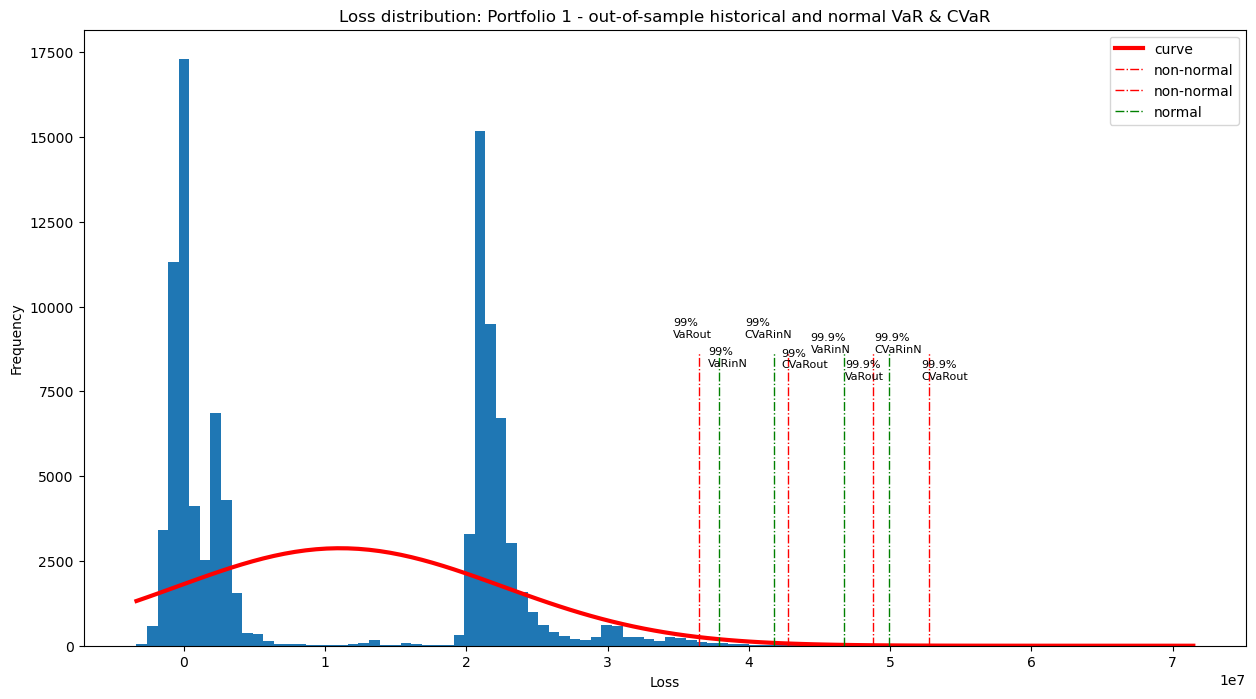

In [278]:
plt.figure(figsize=(15,8))
fig = plt.gcf()
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[0]), 100)
normf = (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
# Historical 1-day VaR
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day VaR
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
# Historical 1-day CVaR
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day CVaR
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
plt.text(0.95 * VaRout[0,0], max(frequencyCounts) / 1.9, '99%\nVaRout',fontsize=8)#99
plt.text(0.98 * VaRinN[0,0], max(frequencyCounts) / 2.1, '99%\nVaRinN',fontsize=8)
plt.text(0.99 * CVaRout[0,0], max(frequencyCounts) / 2.11, '99%\nCVaRout',fontsize=8)
plt.text(0.95 * CVaRinN[0,0], max(frequencyCounts) / 1.9, '99%\nCVaRinN',fontsize=8)
plt.text(0.96 * VaRout[0,1], max(frequencyCounts) / 2.2, '99.9%\nVaRout',fontsize=8)#99.9
plt.text(0.95 * VaRinN[0,1], max(frequencyCounts) / 2.0, '99.9%\nVaRinN',fontsize=8)
plt.text(0.99 * CVaRout[0,1], max(frequencyCounts) / 2.2, '99.9%\nCVaRout',fontsize=8)
plt.text(0.98 * CVaRinN[0,1], max(frequencyCounts) / 2.0, '99.9%\nCVaRinN',fontsize=8)
plt.title('Loss distribution: Portfolio 1 - out-of-sample historical and normal VaR & CVaR')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend(["curve", "non-normal", "non-normal","normal"], loc ="upper right")
plt.show()

### Portfolio 1 distribution MC1 in-sample results
### VaR and CVaR at quantile levels 99% and 99.9%

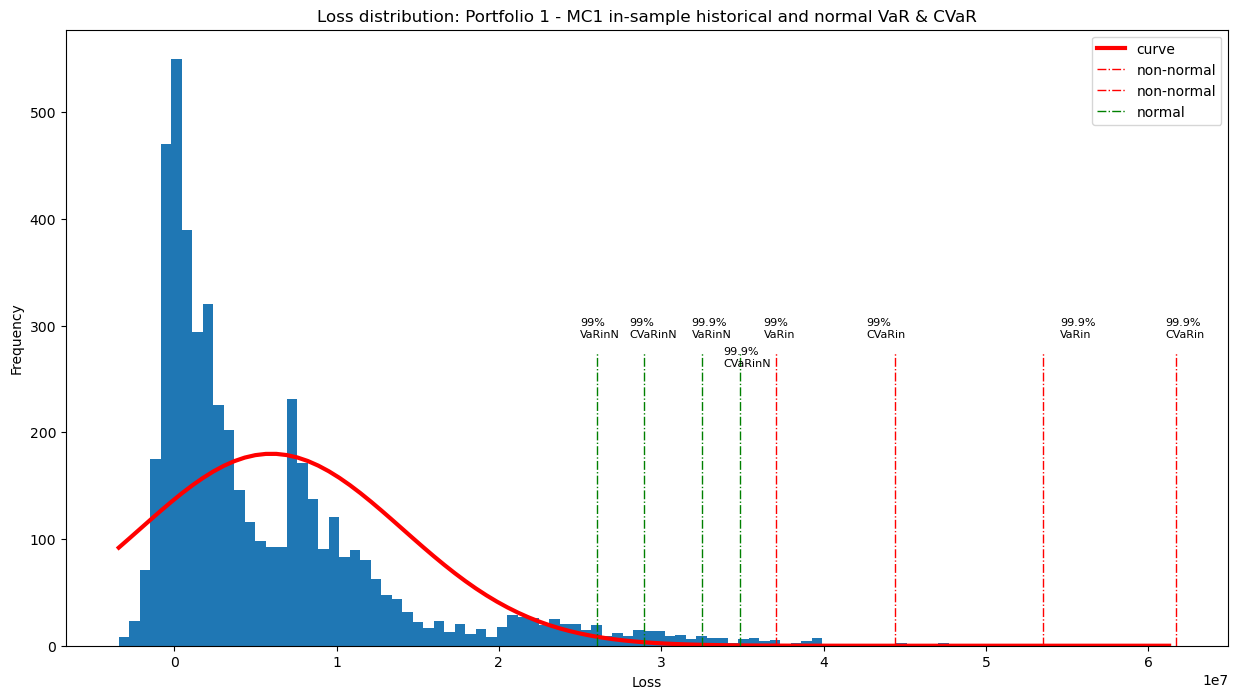

In [286]:
plt.figure(figsize=(15,8))
fig = plt.gcf()
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[0]), 100)
normf = (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
# Historical 1-day VaR
plt.plot([VaRinMC1[0,0].mean(), VaRinMC1[0,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinMC1[0,1].mean(), VaRinMC1[0,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day VaR
plt.plot([VaRinN1[0,0].mean(), VaRinN1[0,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinN1[0,1].mean(), VaRinN1[0,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
# Historical 1-day CVaR
plt.plot([CVaRinMC1[0,0].mean(), CVaRinMC1[0,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinMC1[0,1].mean(), CVaRinMC1[0,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day CVaR
plt.plot([CVaRinN1[0,0].mean(), CVaRinN1[0,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinN1[0,1].mean(), CVaRinN1[0,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
plt.text(0.98 * VaRinMC1[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRin',fontsize=8)#99
plt.text(0.96 * VaRinN1[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRinN',fontsize=8)
plt.text(0.96 * CVaRinMC1[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRin',fontsize=8)
plt.text(0.97 * CVaRinN1[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRinN',fontsize=8)
plt.text(1.02 * VaRinMC1[0,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nVaRin',fontsize=8)#99.9
plt.text(0.98 * VaRinN1[0,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nVaRinN',fontsize=8)
plt.text(0.99 * CVaRinMC1[0,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nCVaRin',fontsize=8)
plt.text(0.97 * CVaRinN1[0,1].mean(), max(frequencyCounts) / 2.1, '99.9%\nCVaRinN',fontsize=8)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss distribution: Portfolio 1 - MC1 in-sample historical and normal VaR & CVaR')
plt.legend(["curve", "non-normal", "non-normal","normal"], loc ="upper right")
plt.show()

### Portfolio 1 distribution MC2 in-sample results
### VaR and CVaR at quantile levels 99% and 99.9%

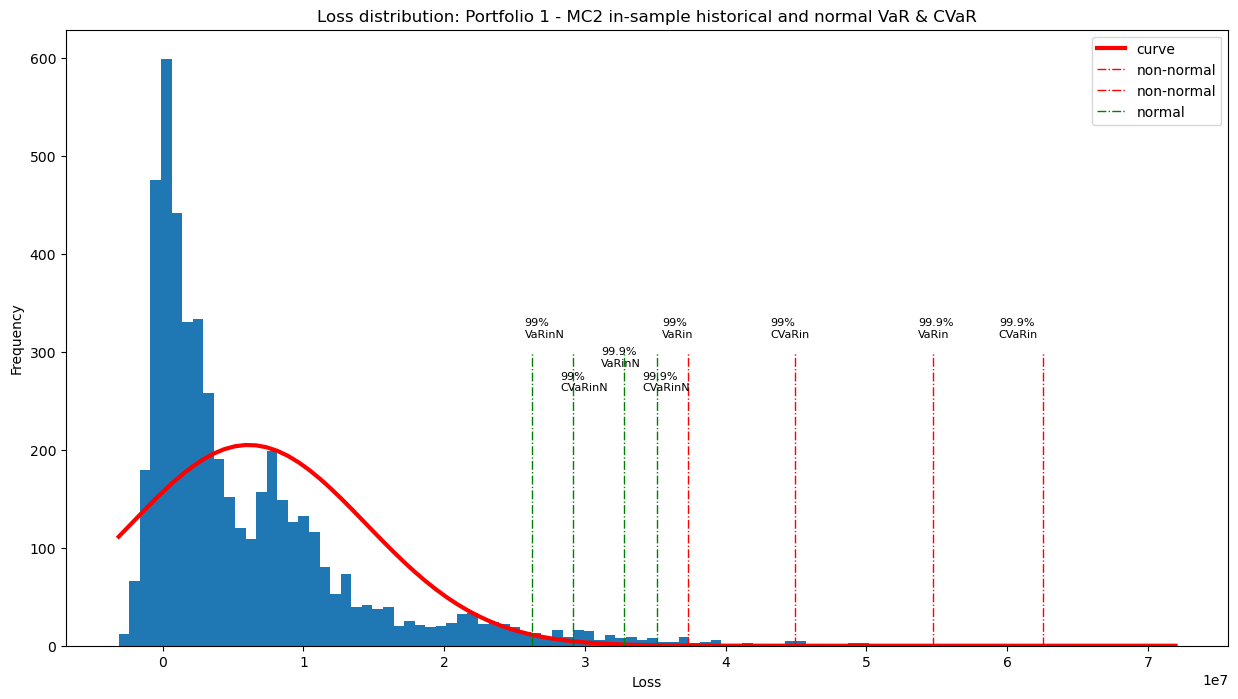

In [287]:
plt.figure(figsize=(15,8))
fig = plt.gcf()
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[0]), 100)
normf = (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
# Historical 1-day VaR
plt.plot([VaRinMC2[0,0].mean(), VaRinMC2[0,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinMC2[0,1].mean(), VaRinMC2[0,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day VaR
plt.plot([VaRinN2[0,0].mean(), VaRinN2[0,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinN2[0,1].mean(), VaRinN2[0,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
# Historical 1-day CVaR
plt.plot([CVaRinMC2[0,0].mean(), CVaRinMC2[0,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinMC2[0,1].mean(), CVaRinMC2[0,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day CVaR
plt.plot([CVaRinN2[0,0].mean(), CVaRinN2[0,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinN2[0,1].mean(), CVaRinN2[0,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
plt.text(0.95 * VaRinMC2[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRin',fontsize=8)#99
plt.text(0.98 * VaRinN2[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRinN',fontsize=8)
plt.text(0.96 * CVaRinMC2[0,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRin',fontsize=8)
plt.text(0.97 * CVaRinN2[0,0].mean(), max(frequencyCounts) / 2.3, '99%\nCVaRinN',fontsize=8)
plt.text(0.98 * VaRinMC2[0,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nVaRin',fontsize=8)#99.9
plt.text(0.95 * VaRinN2[0,1].mean(), max(frequencyCounts) / 2.1, '99.9%\nVaRinN',fontsize=8)
plt.text(0.95 * CVaRinMC2[0,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nCVaRin',fontsize=8)
plt.text(0.97 * CVaRinN2[0,1].mean(), max(frequencyCounts) / 2.3, '99.9%\nCVaRinN',fontsize=8)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss distribution: Portfolio 1 - MC2 in-sample historical and normal VaR & CVaR')
plt.legend(["curve", "non-normal", "non-normal","normal"], loc ="upper right")
plt.show()

### Portfolio 2 true loss distribution 100000 out-of-sample results
### VaR and CVaR at quantile levels 99% and 99.9%

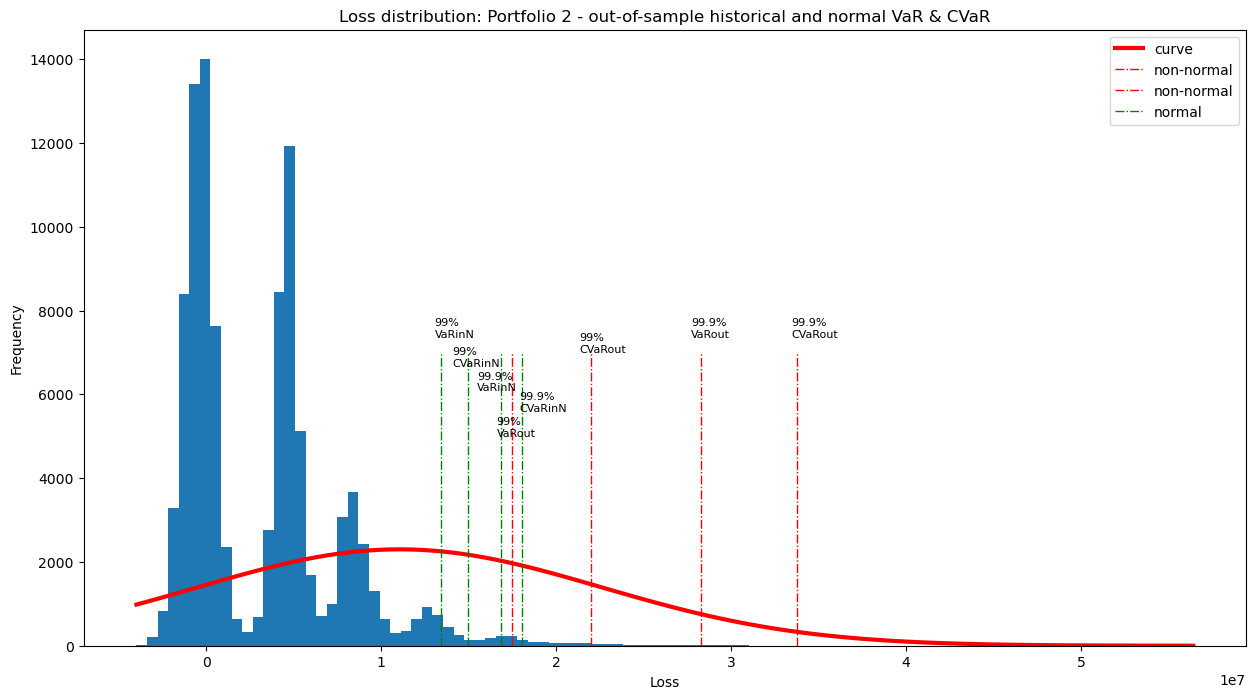

In [308]:
plt.figure(figsize=(15,8))
fig = plt.gcf()
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_out,x0[1]), 100)
normf = (1 / (np.std(np.dot(Losses_out,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.dot(Losses_out,x0[0]))) / np.std(np.dot(Losses_out,x0[0]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
# Historical 1-day VaR
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day VaR
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
# Historical 1-day CVaR
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day CVaR
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
plt.text(0.95 * VaRout[1,0], max(frequencyCounts) / 2.8, '99%\nVaRout',fontsize=8)#99
plt.text(0.97 * VaRinN[1,0], max(frequencyCounts) / 1.9, '99%\nVaRinN',fontsize=8)
plt.text(0.97 * CVaRout[1,0], max(frequencyCounts) / 2.0, '99%\nCVaRout',fontsize=8)
plt.text(0.94 * CVaRinN[1,0], max(frequencyCounts) / 2.1, '99%\nCVaRinN',fontsize=8)
plt.text(0.98 * VaRout[1,1], max(frequencyCounts) / 1.9, '99.9%\nVaRout',fontsize=8)#99.9
plt.text(0.92 * VaRinN[1,1], max(frequencyCounts) / 2.3, '99.9%\nVaRinN',fontsize=8)
plt.text(0.99 * CVaRout[1,1], max(frequencyCounts) / 1.9, '99.9%\nCVaRout',fontsize=8)
plt.text(0.99 * CVaRinN[1,1], max(frequencyCounts) / 2.5, '99.9%\nCVaRinN',fontsize=8)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss distribution: Portfolio 2 - out-of-sample historical and normal VaR & CVaR')
plt.legend(["curve", "non-normal", "non-normal","normal"], loc ="upper right")
plt.show()

### Portfolio 2 distribution MC1 in-sample results
### VaR and CVaR at quantile levels 99% and 99.9%

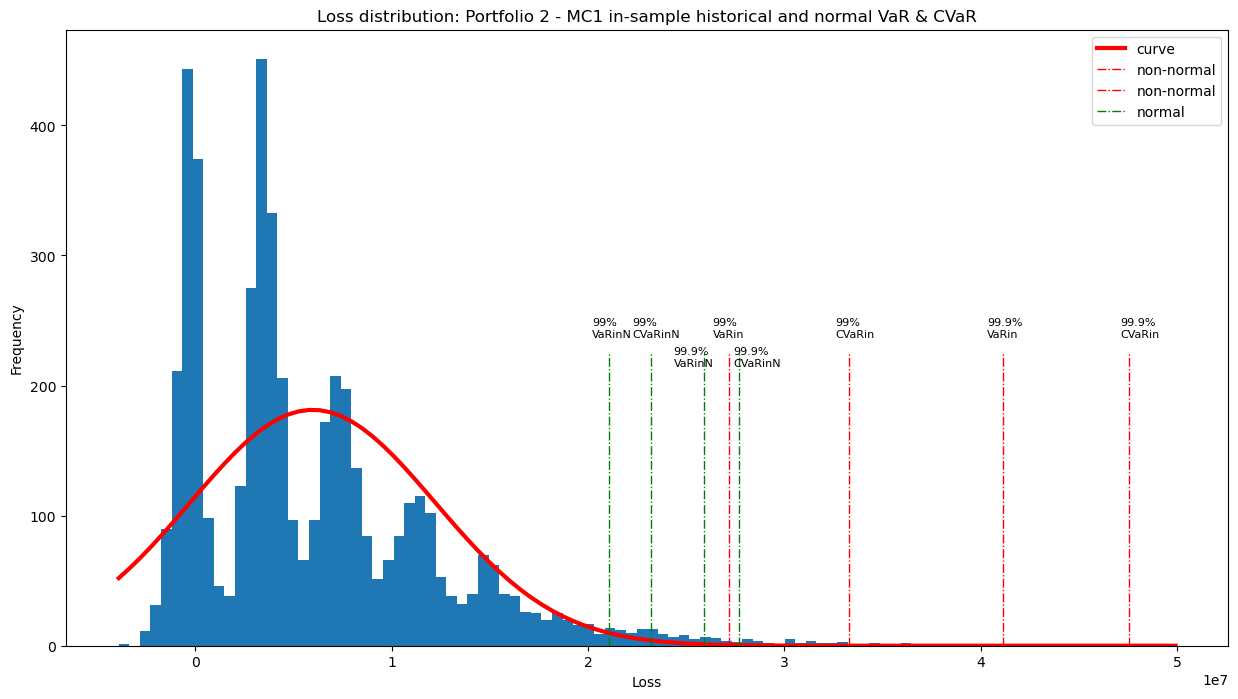

In [313]:
plt.figure(figsize=(15,8))
fig = plt.gcf()
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC1,x0[1]), 100)
normf = (1 / (np.std(np.dot(Losses_inMC1,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.dot(Losses_inMC1,x0[1]))) / np.std(np.dot(Losses_inMC1,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
# Historical 1-day VaR
plt.plot([VaRinMC1[1,0].mean(), VaRinMC1[1,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinMC1[1,1].mean(), VaRinMC1[1,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day VaR
plt.plot([VaRinN1[1,0].mean(), VaRinN1[1,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinN1[1,1].mean(), VaRinN1[1,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
# Historical 1-day CVaR
plt.plot([CVaRinMC1[1,0].mean(), CVaRinMC1[1,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinMC1[1,1].mean(), CVaRinMC1[1,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day CVaR
plt.plot([CVaRinN1[1,0].mean(), CVaRinN1[1,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinN1[1,1].mean(), CVaRinN1[1,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
plt.text(0.97 * VaRinMC1[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRin',fontsize=8)#99
plt.text(0.96 * VaRinN1[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRinN',fontsize=8)
plt.text(0.98 * CVaRinMC1[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRin',fontsize=8)
plt.text(0.96 * CVaRinN1[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRinN',fontsize=8)
plt.text(0.98 * VaRinMC1[1,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nVaRin',fontsize=8)#99.9
plt.text(0.94 * VaRinN1[1,1].mean(), max(frequencyCounts) / 2.1, '99.9%\nVaRinN',fontsize=8)
plt.text(0.99 * CVaRinMC1[1,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nCVaRin',fontsize=8)
plt.text(0.99 * CVaRinN1[1,1].mean(), max(frequencyCounts) / 2.1, '99.9%\nCVaRinN',fontsize=8)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss distribution: Portfolio 2 - MC1 in-sample historical and normal VaR & CVaR')
plt.legend(["curve", "non-normal", "non-normal","normal"], loc ="upper right")
plt.show()

### Portfolio 2 distribution MC2 in-sample results
### VaR and CVaR at quantile levels 99% and 99.9%

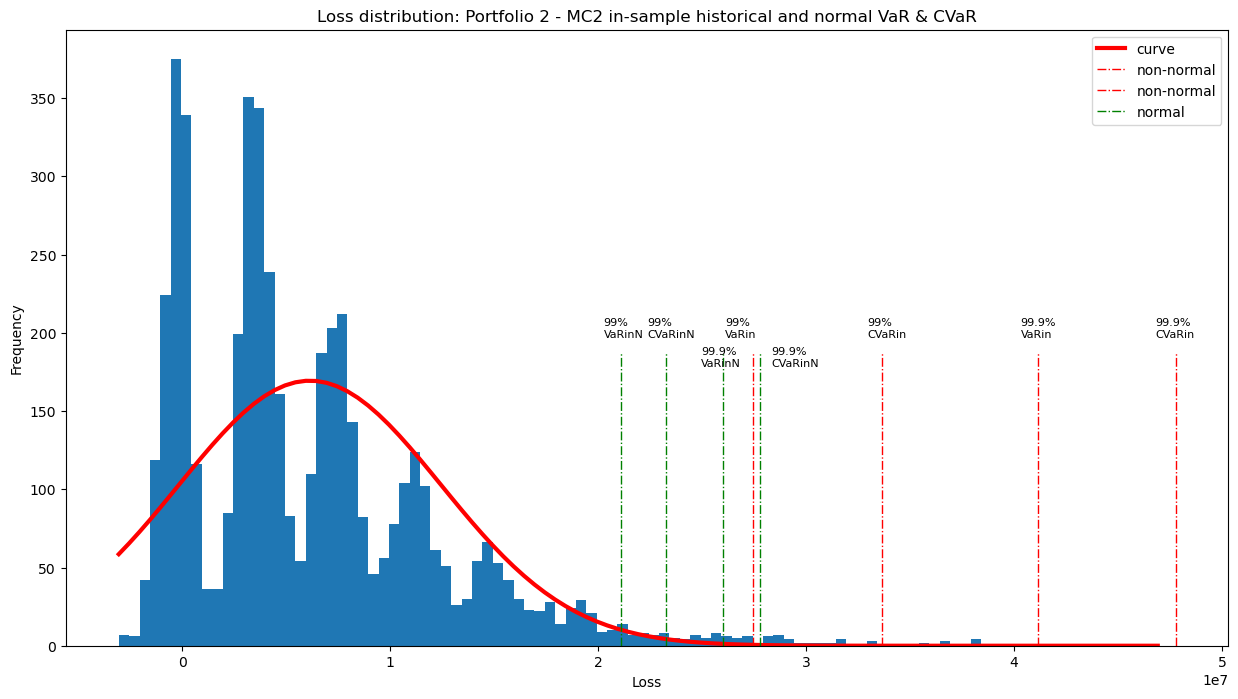

In [320]:
plt.figure(figsize=(15,8))
fig = plt.gcf()
frequencyCounts, binLocations, patches = plt.hist(np.dot(Losses_inMC2,x0[1]), 100)
normf = (1 / (np.std(np.dot(Losses_inMC2,x0[1])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(np.dot(Losses_inMC2,x0[1]))) / np.std(np.dot(Losses_inMC2,x0[1]))) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)
# Historical 1-day VaR
plt.plot([VaRinMC2[1,0].mean(), VaRinMC2[1,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinMC2[1,1].mean(), VaRinMC2[1,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day VaR
plt.plot([VaRinN2[1,0].mean(), VaRinN2[1,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([VaRinN2[1,1].mean(), VaRinN2[1,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
# Historical 1-day CVaR
plt.plot([CVaRinMC2[1,0].mean(), CVaRinMC2[1,0].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinMC2[1,1].mean(), CVaRinMC2[1,1].mean()], [0, max(frequencyCounts) / 2], color='r', linewidth=1, linestyle='-.')#99.9
# Normal 1-day CVaR
plt.plot([CVaRinN2[1,0].mean(), CVaRinN2[1,0].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99%
plt.plot([CVaRinN2[1,1].mean(), CVaRinN2[1,1].mean()], [0, max(frequencyCounts)/2], color='g', linewidth=1, linestyle='-.')#99.9
plt.text(0.95 * VaRinMC2[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRin',fontsize=8)#99
plt.text(0.96 * VaRinN2[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nVaRinN',fontsize=8)
plt.text(0.98 * CVaRinMC2[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRin',fontsize=8)
plt.text(0.96 * CVaRinN2[1,0].mean(), max(frequencyCounts) / 1.9, '99%\nCVaRinN',fontsize=8)
plt.text(0.98 * VaRinMC2[1,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nVaRin',fontsize=8)#99.9
plt.text(0.96 * VaRinN2[1,1].mean(), max(frequencyCounts) / 2.1, '99.9%\nVaRinN',fontsize=8)
plt.text(0.98 * CVaRinMC2[1,1].mean(), max(frequencyCounts) / 1.9, '99.9%\nCVaRin',fontsize=8)
plt.text(1.02 * CVaRinN2[1,1].mean(), max(frequencyCounts) / 2.1, '99.9%\nCVaRinN',fontsize=8)
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.title('Loss distribution: Portfolio 2 - MC2 in-sample historical and normal VaR & CVaR')
plt.legend(["curve", "non-normal", "non-normal","normal"], loc ="upper right")
plt.show()

### Analyze sampling error

In [321]:
# Build tables for errors
# MC  approximations (16 rows)
se_VaR = []
se_CVaR = []
r_name = []
for p in range(2):
    for q in range(alphas.size):
        alf = alphas[q]
        se_VaR.append((VaRinMC1[p,q].mean()-VaRout[p,q])/VaRout[p,q]*100)
        se_VaR.append((VaRinMC2[p,q].mean()-VaRout[p,q])/VaRout[p,q]*100)
        r_name.append(str(alf*100)+'%,'+' Portfolio'+str(p+1)+ ', MC1')
        r_name.append(str(alf*100)+'%,'+' Portfolio'+str(p+1)+ ', MC2')
        se_CVaR.append((CVaRinMC1[p,q].mean()-CVaRout[p,q])/CVaRout[p,q]*100)
        se_CVaR.append((CVaRinMC2[p,q].mean()-CVaRout[p,q])/CVaRout[p,q]*100)

df_mc=pd.DataFrame(data = {'VaR': se_VaR, 'CVaR': se_CVaR},index=r_name)  
df_mc

,VaR,CVaR
"99.0%, Portfolio1, MC1",1.620943,3.881730
"99.0%, Portfolio1, MC2",2.468572,5.162086
"99.9%, Portfolio1, MC1",9.712954,16.886701
"99.9%, Portfolio1, MC2",12.299162,18.520184
"99.0%, Portfolio2, MC1",55.378738,51.326466
"99.0%, Portfolio2, MC2",57.140767,52.972860
"99.9%, Portfolio2, MC1",45.419193,40.797192
"99.9%, Portfolio2, MC2",45.451333,41.433296


### Analyze model error

In [322]:
me_VaR = []
me_CVaR = []
r_name = []
for p in range(2):
    for q in range(alphas.size):
        alf = alphas[q]
        me_VaR.append((VaRinN1[p,q].mean()-VaRout[p,q])/VaRout[p,q]*100)
        me_VaR.append((VaRinN2[p,q].mean()-VaRout[p,q])/VaRout[p,q]*100)
        r_name.append(str(alf*100)+'%,'+' Portfolio'+str(p+1)+ ', MC1')
        r_name.append(str(alf*100)+'%,'+' Portfolio'+str(p+1)+ ', MC2')
        me_CVaR.append((CVaRinN1[p,q].mean()-CVaRout[p,q])/CVaRout[p,q]*100)
        me_CVaR.append((CVaRinN2[p,q].mean()-CVaRout[p,q])/CVaRout[p,q]*100)

df_N=pd.DataFrame(data = {'VaR': me_VaR, 'CVaR': me_CVaR},index=r_name)  
df_N

,VaR,CVaR
"99.0%, Portfolio1, MC1",-28.566142,-32.379087
"99.0%, Portfolio1, MC2",-27.995699,-31.836230
"99.9%, Portfolio1, MC1",-33.315821,-33.930759
"99.9%, Portfolio1, MC2",-32.777648,-33.396031
"99.0%, Portfolio2, MC1",20.384668,5.533889
"99.0%, Portfolio2, MC2",20.761417,5.861356
"99.9%, Portfolio2, MC1",-8.387274,-18.046424
"99.9%, Portfolio2, MC2",-8.105484,-17.795556
